In [2]:
import os;
os.environ['KMP_DUPLICATE_LIB_OK']='True';

In [19]:
import tensorflow as tf;
import numpy as np;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;

In [4]:
class TensorProjectionLayer(tf.keras.layers.Layer):
    def __init__(self, q1,q2,q3,activation=tf.keras.activations.linear, bias=True):
        super(TensorProjectionLayer, self).__init__()
        self.q1 = int(q1);
        self.q2 = int(q2);
        self.q3 = int(q3);
        self.e1 = 10**-6;
        self.e2 = 10**-6;
        self.e3 = 10**-6;
        self.activation = activation;
        self.bias = bias;
    
    def build(self, input_shape):
        self.p1 = int(input_shape[1]);
        self.p2 = int(input_shape[2]);
        self.p3 = int(input_shape[3]);
        
        if(self.q1 < self.p1):
            self.W1 = self.add_weight("W1",shape=[self.p1, self.q1],initializer='normal', trainable=True);
        if(self.q2 < self.p2):
            self.W2 = self.add_weight("W2",shape=[self.p2, self.q2],initializer='normal', trainable=True);
        if(self.q3 < self.p3):
            self.W3 = self.add_weight("W3",shape=[self.p3, self.q3],initializer='normal', trainable=True);
        if(self.bias == True):
            self.b    = self.add_weight("b",shape=[self.q1, self.q2, self.q3],initializer='normal', trainable=True);
        super(TensorProjectionLayer, self).build(input_shape);

    # suppose that T: n x t1 x t2 x t3
    # k=1,2,3
    def kmode_product(self, T, A, k):

        # number of the observations
        n  = tf.shape(T)[0];
        t1 = tf.shape(T)[1];
        t2 = tf.shape(T)[2];
        t3 = tf.shape(T)[3];
        uk = tf.shape(A)[0];
        
        # Compute the size of the output-tensor
        if k == 1:
            new_shape = [n, uk, t2, t3];
        elif k == 2:
            new_shape = [n, t1, uk, t3];
        elif k == 3:
            new_shape = [n, t1, t2, uk];
        
        # Compute T xk A
        A = tf.expand_dims(A, 0);
        An =  tf.tile(A, [n, 1, 1]);
        Tk = self.unfold(T,k);
        ATk = tf.linalg.matmul(An, Tk);
        TxkA = self.fold(ATk, k, new_shape);
        return TxkA;
    
    def fold(self, Tk, k, new_shape):
        
        # this is Tensorly-version
        
        a = new_shape;
        
        if k == 1:
            reshape_order =  [0,1,2,3];
            permute_order = [0,1,2,3];
        elif k ==2:
            reshape_order =  [0,2,1,3];
            permute_order = [0,2,1,3];
        elif k == 3:
            reshape_order =  [0,3,1,2];
            permute_order = [0,2,3,1];
        
        new_shape = [a[reshape_order[0]], a[reshape_order[1]], a[reshape_order[2]], a[reshape_order[3]]];
        
        T_ = tf.reshape(Tk, new_shape);
        T = tf.transpose(T_, perm=permute_order);
        return T;
  
    def unfold(self, T, k):
        n  =  tf.shape(T)[0];
        t1 = tf.shape(T)[1];
        t2 = tf.shape(T)[2];
        t3 = tf.shape(T)[3];
        
        if k == 1:
            new_shape = [n, t1,t2*t3];
            A = T;
        elif k ==2:
            new_shape = [n, t2,t3*t1];
            A = tf.transpose(T, perm=[0,2,1,3]);
        elif k ==3:
            new_shape = [n, t3,t1*t2];
            A = tf.transpose(T, perm=[0,3,1,2]);
        
        Tk = tf.reshape(A,new_shape);
        
        return Tk;

    def call(self, X):
        n = tf.shape(X)[0];
        
        if self.q1 < self.p1:
            Iq1 = tf.eye(self.q1);
            W1T = tf.transpose(self.W1, perm=[1,0]);
            M1 = tf.math.add(tf.linalg.matmul(W1T,self.W1), Iq1 * self.e1);
            sqrtM1 = tf.linalg.sqrtm(M1);
            G1 = tf.linalg.inv(sqrtM1);
            U1 = tf.linalg.matmul(self.W1, G1); # p1 x q1
            U1T = tf.transpose(U1, perm=[1,0]); # q1 x p1
        
        if self.q2 < self.p2:
            Iq2 = tf.eye(self.q2);
            W2T = tf.transpose(self.W2, perm=[1,0]);
            M2 = tf.math.add(tf.linalg.matmul(W2T,self.W2), Iq2 * self.e2);
            sqrtM2 = tf.linalg.sqrtm(M2);
            G2 = tf.linalg.inv(sqrtM2);
            U2 = tf.linalg.matmul(self.W2, G2); # p2 x q2
            U2T = tf.transpose(U2, perm=[1,0]); # q2 x p2
            
        if self.q3 < self.p3:
            Iq3 = tf.eye(self.q3);
            W3T = tf.transpose(self.W3, perm=[1,0]);
            M3 = tf.math.add(tf.linalg.matmul(W3T,self.W3), Iq3 * self.e3);
            sqrtM3 = tf.linalg.sqrtm(M3);
            G3 = tf.linalg.inv(sqrtM3);
            U3 = tf.linalg.matmul(self.W3, G3); # p3 x q3
            U3T = tf.transpose(U3, perm=[1,0]); # q3 x p3

    
        Z = X;
        
        if self.q1 < self.p1:
            Z = self.kmode_product(Z, U1T, 1);
        if self.q2 < self.p2:
            Z = self.kmode_product(Z, U2T, 2);
        if self.q3 < self.p3:
            Z = self.kmode_product(Z, U3T, 3);

        # This is necessary. But I don't know why...
        Z = tf.reshape(Z, [n,self.q1,self.q2,self.q3]);
        
        if self.bias == True:
            Z = tf.add(Z,self.b);

        return self.activation(Z);

In [6]:
batch_size = 100;
num_classes = 10;
epochs = 2;
# prepare data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data();

img_rows, img_cols = 28, 28

# 場合分け
if tf.keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')   # int型をfloat32型に変換
x_test = x_test.astype('float32')
x_train /= 255                        # [0-255]の値を[0.0-1.0]に変換
x_test /= 255
print(x_train.shape[0], 'train samples');
print(x_test.shape[0], 'test samples');
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [23]:
### TensorProjection Layer ###
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same',activation='relu', input_shape=input_shape));
model.add(tf.keras.layers.AveragePooling2D((2,2)))
#model.add(TensorProjectionLayer(14, 14, 16, tf.keras.activations.linear, False)) # （28，28，64） ---> (6,6,8)
#model.add(tf.keras.layers.Dropout(0.5));

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3),strides=1, padding='same',activation='relu'));
model.add(tf.keras.layers.AveragePooling2D((2,2)))
#model.add(TensorProjectionLayer(7, 7, 32, tf.keras.activations.relu, False)) # （28，28，64） ---> (6,6,8)
#model.add(tf.keras.layers.Dropout(0.5));

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(640, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5));
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])



In [8]:
# fit
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0]);
print('Test accuracy:', score[1]);
model.save_weights('tensor-projection-layer_weights.h5');

# load from trained model
#model.load_weights('tensor-projection-layer_weights.h5');



Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 39s 647us/sample - loss: 0.6105 - accuracy: 0.7774 - val_loss: 0.4201 - val_accuracy: 0.8449
Epoch 2/2
60000/60000 [==============================] - 38s 627us/sample - loss: 0.4036 - accuracy: 0.8535 - val_loss: 0.3632 - val_accuracy: 0.8685
Test loss: 0.36319332785606384
Test accuracy: 0.8685


TypeError: Object of type float32 is not JSON serializable

In [22]:
# save history
history_json = pd.DataFrame(history.history);
with open('history.json', 'w') as f:
     history_json.to_json(f);

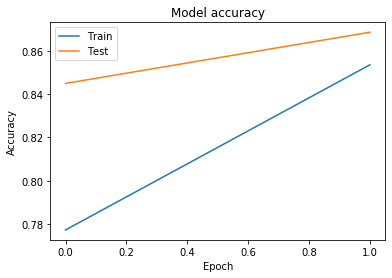

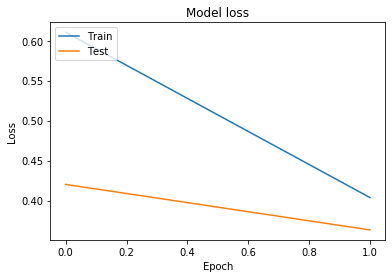

In [16]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('accuracy.png');
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('loss.png');
plt.show()


{'loss': [0.6105310989419619, 0.4036350949356953],
 'accuracy': [0.77735, 0.8534833],
 'val_loss': [0.42014373421669005, 0.3631933230161667],
 'val_accuracy': [0.8449, 0.8685]}

In [24]:
model.summary();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 640)               2007680   
_________________________________________________________________
dropout_2 (Dropout)          (None, 640)              

In [7]:
#### Start Visualization ###

In [8]:
import tensorly as tl;
import numpy as np;
import scipy as sp;
import matplotlib.pyplot;

Using numpy backend.


In [9]:
# Visualization
tensor_projection_layer_name = 'tensor_projection_layer';
conv2d_layer_name = 'conv2d';

# obtain layer
tensor_projection_layer = tf.keras.Model(inputs=model.input, outputs=model.get_layer(tensor_projection_layer_name).output)
conv2d_layer = tf.keras.Model(inputs=model.input, outputs=model.get_layer(conv2d_layer_name).output)

# compute outputs of projection_layer
Z = tensor_projection_layer.predict(x_test[0:100]);

# compute outpus of conv2d layer
X = conv2d_layer.predict(x_test[0:100]);

# load weights of projection layer
tensor_projection_weights = tensor_projection_layer.get_weights();
W1 = tensor_projection_weights[2];
W2 = tensor_projection_weights[3];
W3 = tensor_projection_weights[4];
print(tensor_projection_weights[0].shape) # parameter of the previous conv2D layer
print(tensor_projection_weights[1].shape) # parameter of the previsou conv2D layer
print(tensor_projection_weights[2].shape) # W1
print(tensor_projection_weights[3].shape) # W2
print(tensor_projection_weights[4].shape) # W3

(3, 3, 1, 32)
(32,)
(28, 7)
(28, 7)
(32, 7)


In [10]:
# compute
def tensor_restore(Z,W1,W2,W3):
    # obtain n,p1,p2,q1,q2:
    q1 = Z.shape[1];
    q2 = Z.shape[2];
    q3 = Z.shape[3];
    
    p1 = W1.shape[0];
    p2 = W2.shape[0];
    p3 = W3.shape[0];
    
    Iq1 = np.eye(q1);
    Iq2 = np.eye(q2);
    Iq3 = np.eye(q3);
    

    W1T = np.transpose(W1,(1,0)); # [p1,q1] -> [q1,p1]
    W2T = np.transpose(W2,(1,0)); # [p2,q2] -> [q2,p2]
    W3T = np.transpose(W3,(1,0)); # [p3,q3] -> [q3,p3]
    
    M1 = np.matmul(W1T,W1) + 0.01*Iq1;
    M2 = np.matmul(W2T,W2) + 0.01*Iq2;
    M3 = np.matmul(W3T,W3) + 0.01*Iq3;
    
    G1 = sp.linalg.inv(sp.linalg.sqrtm(M1));
    G2 = sp.linalg.inv(sp.linalg.sqrtm(M2));
    G3 = sp.linalg.inv(sp.linalg.sqrtm(M3));
    
    U1 = np.matmul(W1,G1); # [p1,q1]
    U2 = np.matmul(W2,G2); # [p2,q2]
    U3 = np.matmul(W3,G3); # [p3,q3]
    
    return tl.tenalg.multi_mode_dot(Z, (U1,U2,U3), modes=(1,2,3));    

In [11]:
X_tilde = tensor_restore(Z,W1,W2,W3);

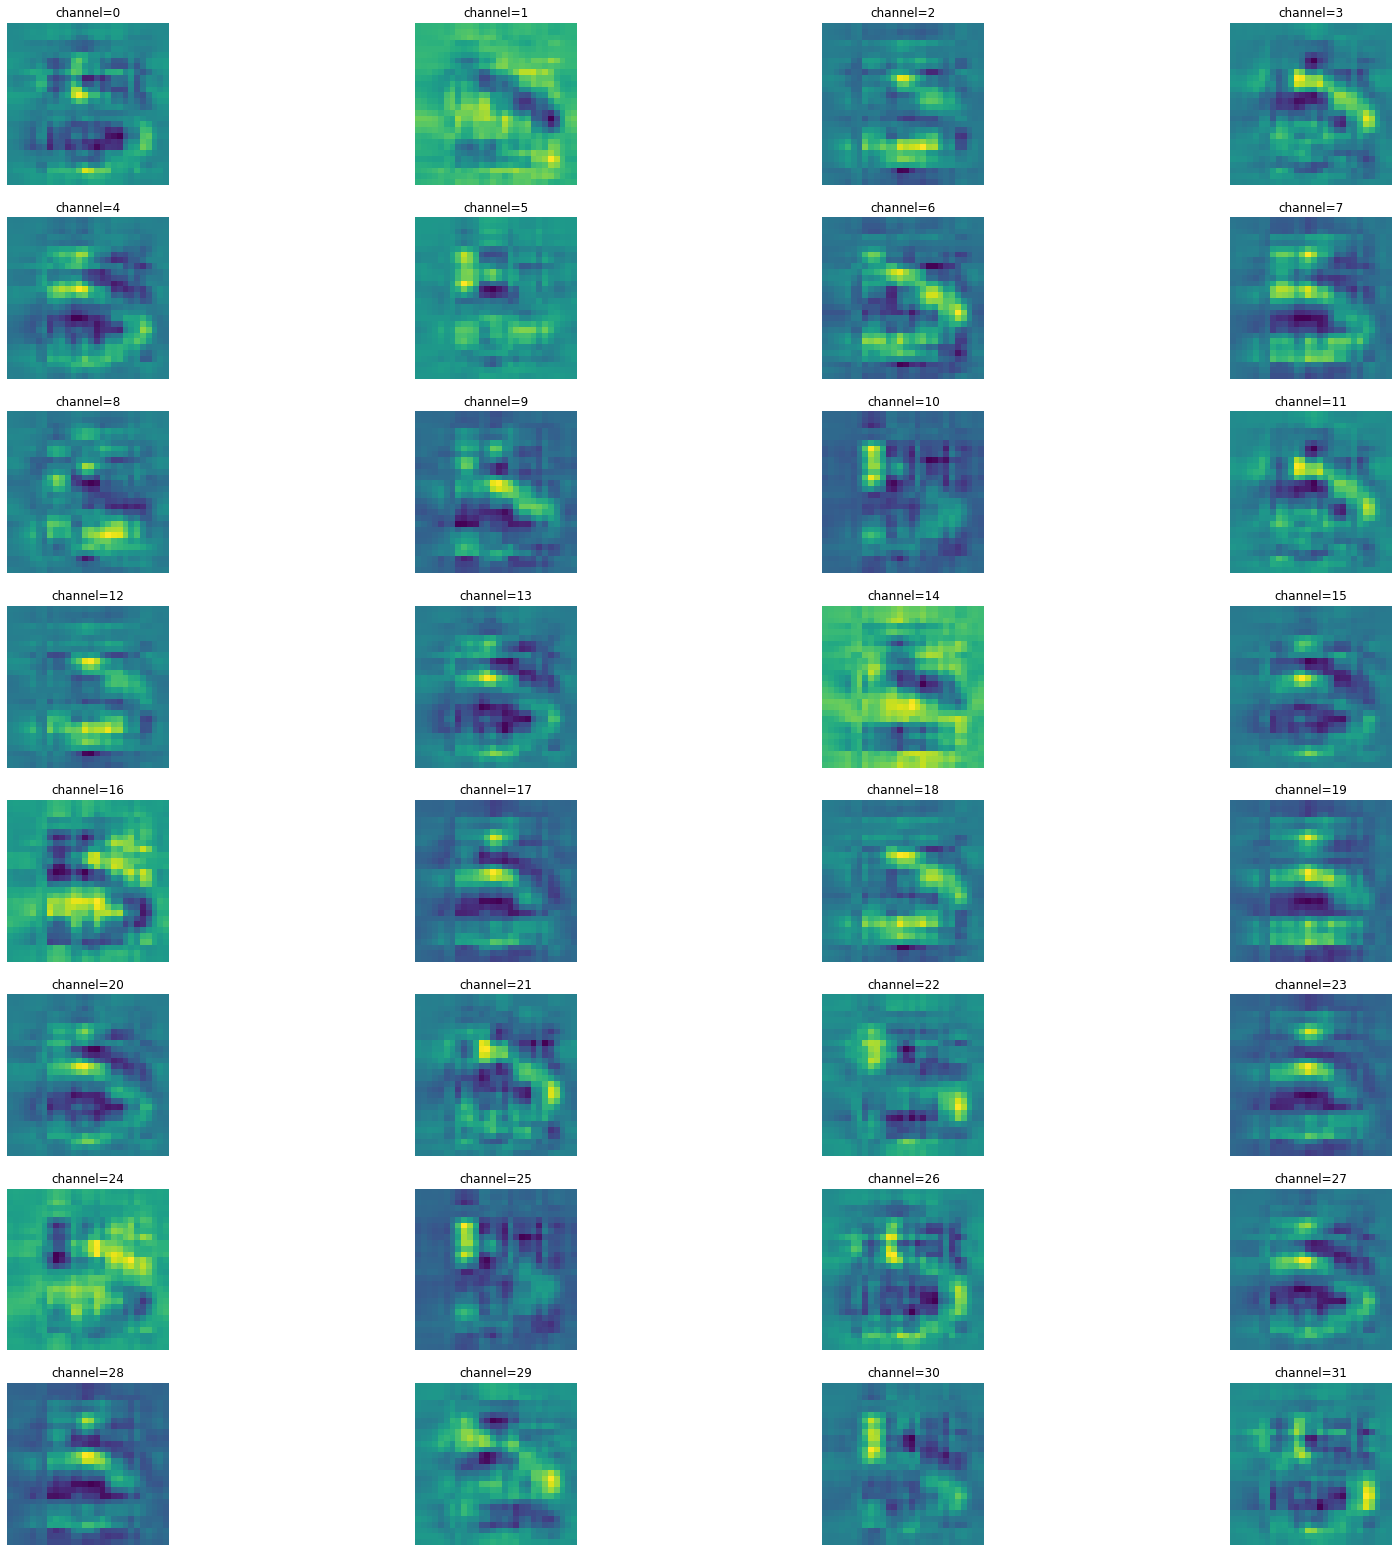

In [12]:
num = 15; # observation
fig = matplotlib.pyplot.figure(figsize=(28, 28))
for c in range(32):
    ax = fig.add_subplot(8, 4, c+1)
    ax.imshow(X_tilde[num,:,:,c])
    ax.set_axis_off()
    ax.set_title("channel={}".format(c))
matplotlib.pyplot.show();

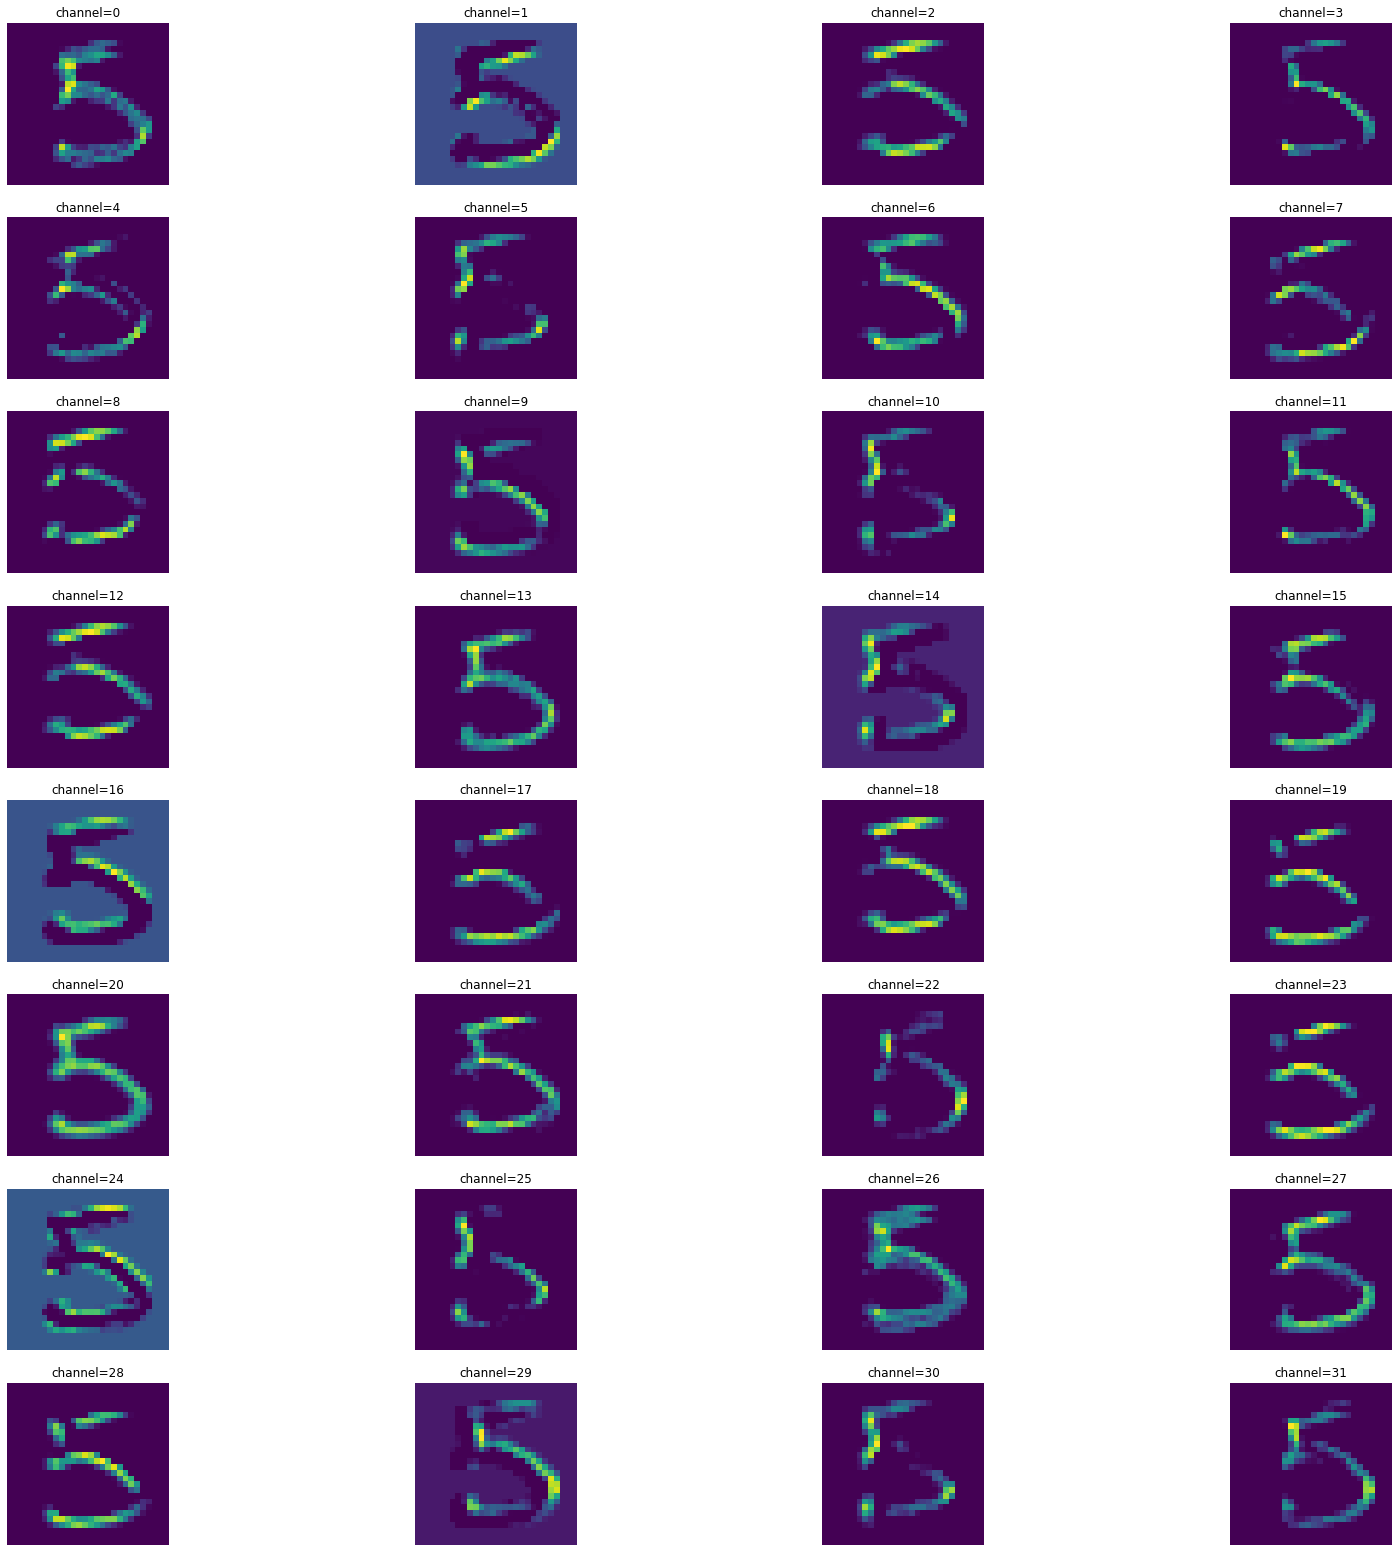

In [13]:
# show conv2d output
num = 15; # observation
fig = matplotlib.pyplot.figure(figsize=(28, 28))
for c in range(32):
    ax = fig.add_subplot(8, 4, c+1)
    ax.imshow(X[num,:,:,c]) # cmap='gray'
    ax.set_axis_off()
    ax.set_title("channel={}".format(c))
matplotlib.pyplot.show();

In [14]:
# compute squared error
D = X - X_tilde;
num_obs = 100;
num_ch  = 32;
loss = np.zeros((num_obs,num_ch),dtype=np.float32);
for i in range(num_obs):
    for j in range(num_ch):
        diff_ij = D[i,:,:,j];
        loss[i,j] = np.sum(np.power(diff_ij.flatten('F'),2));

In [15]:
print("Average Loss : sum of loss / (num obs * num ch)");
np.average(loss)

Average Loss : sum of loss / (num obs * num ch)


16.568783